# 02 – Compare Two Songs: MFCC Similarity + PCA
Drop two audio files in `../data/` (e.g., `song_a.wav`, `song_b.wav`).

**What this notebook does**
- Loads two tracks
- Extracts MFCCs and pitch (PYIN)
- Computes cosine similarity of MFCC statistics
- (Optional) Dynamic Time Warping (DTW) similarity on MFCC sequences
- Runs PCA to visualize both tracks in a 2D feature space

**Tip:** Keep clips short (15–30s) for quick iteration.

In [1]:
# !pip install librosa matplotlib numpy scikit-learn --quiet
import os
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import norm

# ---- Configure your two files here ----
file_a = "../notebooks/data/somali_song2.wav"
file_b = "../notebooks/data/somali_song1.wav"

assert os.path.exists(file_a), f"Missing file: {file_a}"
assert os.path.exists(file_b), f"Missing file: {file_b}"

SR = 22050  # analysis sample rate
y_a, sr_a = librosa.load(file_a, sr=SR, mono=True)
y_b, sr_b = librosa.load(file_b, sr=SR, mono=True)

print(f"A: {file_a} | len={len(y_a)/SR:.2f}s  | sr={SR}")
print(f"B: {file_b} | len={len(y_b)/SR:.2f}s  | sr={SR}")

/var/folders/sx/dmmppkp10cd8_53wkh9f7lh40000gn/T/ipykernel_67642/3777777249.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y_a, sr_a = librosa.load(file_a, sr=SR, mono=True)
/Users/khalidibrahim/Desktop/somali-music-feature-explorer/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

In [ ]:
# ---- MFCC features ----
n_mfcc = 20
mfcc_a = librosa.feature.mfcc(y=y_a, sr=SR, n_mfcc=n_mfcc)
mfcc_b = librosa.feature.mfcc(y=y_b, sr=SR, n_mfcc=n_mfcc)

# Summaries for cosine similarity (per-track statistics)
mfcc_a_mean = mfcc_a.mean(axis=1)
mfcc_a_std  = mfcc_a.std(axis=1)
mfcc_b_mean = mfcc_b.mean(axis=1)
mfcc_b_std  = mfcc_b.std(axis=1)

# Two summary vectors: mean and [mean|std] concatenated
vec_a_mean = mfcc_a_mean
vec_b_mean = mfcc_b_mean

vec_a_meanstd = np.concatenate([mfcc_a_mean, mfcc_a_std])
vec_b_meanstd = np.concatenate([mfcc_b_mean, mfcc_b_std])

def cosine_sim(u, v):
    return float(np.dot(u, v) / (norm(u) * norm(v) + 1e-8))

print("Cosine similarity (means only):      ", round(cosine_sim(vec_a_mean, vec_b_mean), 4))
print("Cosine similarity (means + std dev): ", round(cosine_sim(vec_a_meanstd, vec_b_meanstd), 4))

Cosine similarity (means only):       0.9946
Cosine similarity (means + std dev):  0.9935


In [ ]:
from librosa.sequence import dtw, cdist
import numpy as np

def zscore(m):
    return (m - m.mean(axis=1, keepdims=True)) / (m.std(axis=1, keepdims=True) + 1e-8)

Za = zscore(mfcc_a)
Zb = zscore(mfcc_b)

# cosine distance matrix between frames (T_a x T_b)
C = cdist(Za.T, Zb.T, metric='cosine')
wp, cost = dtw(C=C)
dtw_dist = cost[-1, -1] / (len(wp) + 1e-8)
print("DTW normalized distance (MFCC):", round(float(dtw_dist), 4))


DTW normalized distance (MFCC): 0.0


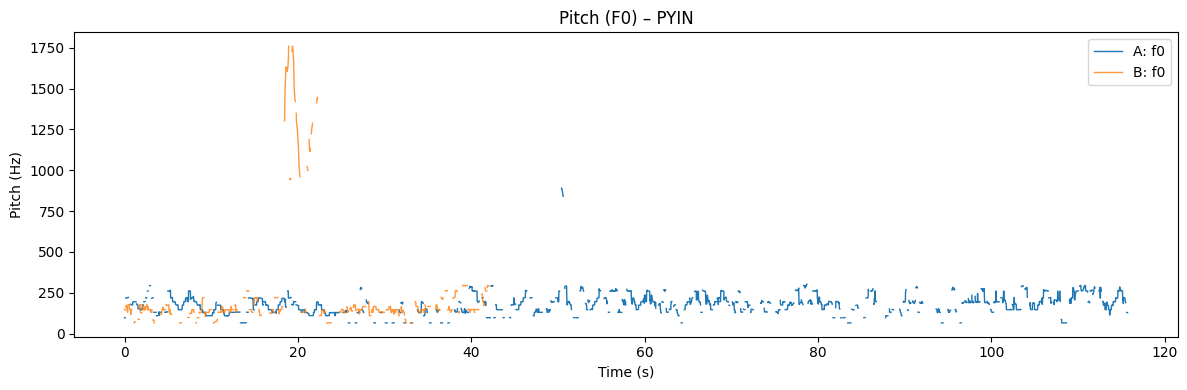

Mean F0 A: 179.69869225498329
Mean F0 B: 239.64158847853696


In [ ]:
# ---- Pitch (PYIN) overview (optional plots) ----
f0_a, vf_a, _ = librosa.pyin(y_a, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SR)
f0_b, vf_b, _ = librosa.pyin(y_b, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SR)
t_a = librosa.times_like(f0_a, sr=SR)
t_b = librosa.times_like(f0_b, sr=SR)

plt.figure(figsize=(12,4))
plt.plot(t_a, f0_a, label="A: f0", linewidth=1)
plt.plot(t_b, f0_b, label="B: f0", linewidth=1, alpha=0.8)
plt.xlabel("Time (s)"); plt.ylabel("Pitch (Hz)")
plt.title("Pitch (F0) – PYIN")
plt.legend(); plt.tight_layout(); plt.show()

print("Mean F0 A:", np.nanmean(f0_a))
print("Mean F0 B:", np.nanmean(f0_b))

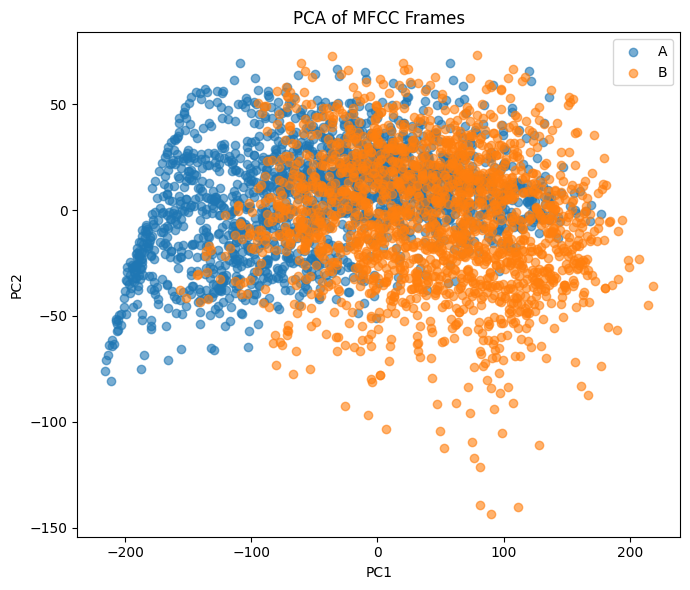

Explained variance ratio: [0.7279597  0.07776498]


In [ ]:
# ---- PCA visualization on pooled MFCC frames ----
n_frames = min(mfcc_a.shape[1], mfcc_b.shape[1])
Xa = mfcc_a[:, :n_frames].T
Xb = mfcc_b[:, :n_frames].T

X = np.vstack([Xa, Xb])
labels = np.array(["A"]*n_frames + ["B"]*n_frames)

pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

plt.figure(figsize=(7,6))
mask_a = labels == "A"
mask_b = ~mask_a
plt.scatter(X2[mask_a,0], X2[mask_a,1], label="A", alpha=0.6)
plt.scatter(X2[mask_b,0], X2[mask_b,1], label="B", alpha=0.6)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA of MFCC Frames")
plt.legend(); plt.tight_layout(); plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

In [ ]:
import os, nbformat as nbf, numpy as np, textwrap, io

project_root = "/mnt/data/somali-music-feature-explorer"
nb_dir = os.path.join(project_root, "notebooks")
reports_dir = os.path.join(project_root, "reports")
os.makedirs(nb_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

# Create Notebook: 03_pitch_class_histograms.ipynb
nb = nbf.v4.new_notebook()
cells = []

cells.append(nbf.v4.new_markdown_cell(
"""# 03 – Pitch‑Class Histograms (Somali vs. Western)

This notebook estimates **fundamental frequency (F0)** using PYIN, converts F0 to **MIDI**,
then computes **pitch‑class histograms** (12 bins modulo octave). It compares two songs via
histogram plots and simple similarity metrics.

**Steps**
1. Load two audio clips (`../data/song_a.wav`, `../data/song_b.wav`)
2. Estimate F0 with `librosa.pyin`
3. Convert Hz → MIDI, take modulo 12 for pitch‑class
4. Make 12‑bin histograms (+ optional smoothing)
5. Compare distributions (cosine similarity, JS divergence)
"""))

cells.append(nbf.v4.new_code_cell(
"""# !pip install librosa numpy matplotlib --quiet
import os, numpy as np, librosa, librosa.display, matplotlib.pyplot as plt
from numpy.linalg import norm

# Configure files
file_a = "../data/song_a.wav"
file_b = "../data/song_b.wav"
assert os.path.exists(file_a) and os.path.exists(file_b), "Add song_a.wav and song_b.wav to ../data/"

SR = 22050
y_a, _ = librosa.load(file_a, sr=SR, mono=True)
y_b, _ = librosa.load(file_b, sr=SR, mono=True)
print("Loaded A len=%.2fs  B len=%.2fs" % (len(y_a)/SR, len(y_b)/SR))"""
))

cells.append(nbf.v4.new_code_cell(
"""# F0 estimation with PYIN
f0_a, _, _ = librosa.pyin(y_a, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SR)
f0_b, _, _ = librosa.pyin(y_b, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SR)

def hz_to_midi(hz):
    hz = np.asarray(hz, dtype=float)
    midi = 69 + 12*np.log2(hz/440.0)
    return midi

# Convert to MIDI, drop NaNs (unvoiced)
midi_a = hz_to_midi(f0_a)
midi_b = hz_to_midi(f0_b)
midi_a = midi_a[~np.isnan(midi_a)]
midi_b = midi_b[~np.isnan(midi_b)]
print("Voiced frames: A =", midi_a.size, " B =", midi_b.size)"""
))

cells.append(nbf.v4.new_code_cell(
"""# Pitch-class (mod 12), histogram, and smoothing
pc_a = np.mod(midi_a, 12.0)
pc_b = np.mod(midi_b, 12.0)

names = np.array(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'])
bins = np.arange(13)  # 0..12

hist_a, _ = np.histogram(pc_a, bins=bins)
hist_b, _ = np.histogram(pc_b, bins=bins)

# normalize to probability
p_a = hist_a / (hist_a.sum() + 1e-8)
p_b = hist_b / (hist_b.sum() + 1e-8)

# Optional circular smoothing (window size=3)
def circular_smooth(p, k=1):
    n = len(p)
    q = np.zeros_like(p, dtype=float)
    for i in range(n):
        for d in range(-k, k+1):
            q[i] += p[(i+d) % n]
    q /= q.sum() + 1e-8
    return q

p_a_sm = circular_smooth(p_a, k=1)
p_b_sm = circular_smooth(p_b, k=1)

# Plot histograms
plt.figure(figsize=(10,4))
x = np.arange(12)
plt.bar(x-0.15, p_a_sm, width=0.3, label="A (smoothed)")
plt.bar(x+0.15, p_b_sm, width=0.3, label="B (smoothed)")
plt.xticks(x, names)
plt.ylabel("Probability")
plt.title("Pitch‑Class Histogram (12‑TET bins)")
plt.legend(); plt.tight_layout(); plt.show()"""
))

cells.append(nbf.v4.new_code_cell(
"""# Similarity metrics
def cosine_sim(p, q):
    return float(np.dot(p, q) / (norm(p)*norm(q) + 1e-12))

def js_divergence(p, q):
    # Jensen-Shannon divergence (symmetric, bounded)
    p = p / (p.sum() + 1e-12)
    q = q / (q.sum() + 1e-12)
    m = 0.5*(p+q)
    def kl(a, b):
        a = np.clip(a, 1e-12, 1.0)
        b = np.clip(b, 1e-12, 1.0)
        return float(np.sum(a * np.log(a/b)))
    return 0.5*kl(p, m) + 0.5*kl(q, m)

print("Cosine similarity (smoothed PCs):", round(cosine_sim(p_a_sm, p_b_sm), 4))
print("JS divergence  (smoothed PCs):   ", round(js_divergence(p_a_sm, p_b_sm), 4))"""
))

cells.append(nbf.v4.new_markdown_cell(
"""### Notes
- If A and B use **different scales**, their pitch‑class histograms will show different peaks.
- Somali pentatonic patterns may emphasize ~5 pitch classes; Western heptatonic (major/minor) tends to spread across 7.
- Microtonal tendencies won’t be captured perfectly by 12‑TET bins; later, consider **cents histograms** (e.g., 24 or 48 bins per octave).
"""))

nb_path = os.path.join(nb_dir, "03_pitch_class_histograms.ipynb")
with open(nb_path, "w", encoding="utf-8") as f:
    nbf.write(nb, f)

# Create a notes template in reports/
notes = """# Analysis Notes (Template)

Use this file to jot down observations after each run.

## Pair: song_a.wav vs song_b.wav
- Tempo (from notebook 01): 
- Beat behavior (steady/free): 
- Pitch summary: mean F0 A=..., B=...
- Pitch‑class peaks (12‑TET): A -> [...], B -> [...]
- Cosine similarity (MFCC means): 
- Cosine similarity (PC hist): 
- JS divergence (PC hist): 
- PCA notes (overlap/separation): 
- Hypothesis: What might explain similarities/differences? (scale, timbre, recording)

## Next tweaks
- Try different k for circular smoothing
- Try a thirds/octaves‑invariant comparison
- Try cents histogram (24 or 48 bins per octave)
"""

with open(os.path.join(reports_dir, "notes_template.md"), "w", encoding="utf-8") as f:
    f.write(notes)

(nb_path, os.path.join(reports_dir, "notes_template.md"))


OSError: [Errno 30] Read-only file system: '/mnt'

In [ ]:
# Requires: pip install nbformat librosa matplotlib numpy
import os
from pathlib import Path
import nbformat as nbf

# --- CHOOSE WHERE TO CREATE THE FILES ---
# 1) Desktop (writable, good default)
project_root = Path.home() / "Desktop" / "somali-music-feature-explorer"

# 2) OR current working directory (uncomment to use)
# project_root = Path.cwd() / "somali-music-feature-explorer"

nb_dir = project_root / "notebooks"
reports_dir = project_root / "reports"
nb_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

# -------- Build notebook: 03_pitch_class_histograms.ipynb --------
nb = nbf.v4.new_notebook()
cells = []

cells.append(nbf.v4.new_markdown_cell(
"""# 03 – Pitch-Class Histograms (Somali vs. Western)

This notebook estimates **fundamental frequency (F0)** using PYIN, converts F0 to **MIDI**,
then computes **pitch-class histograms** (12 bins modulo octave). It compares two songs via
histogram plots and simple similarity metrics.

**Steps**
1. Load two audio clips (`../data/song_a.wav`, `../data/song_b.wav`)
2. Estimate F0 with `librosa.pyin`
3. Convert Hz → MIDI, take modulo 12 for pitch-class
4. Make 12-bin histograms (+ optional smoothing)
5. Compare distributions (cosine similarity, JS divergence)

> Tip: Keep clips short (15–30s) for fast runs.
"""))

cells.append(nbf.v4.new_code_cell(
"""# !pip install librosa numpy matplotlib --quiet
import os, numpy as np, librosa, librosa.display, matplotlib.pyplot as plt
from numpy.linalg import norm

# Configure files
file_a = "../data/song_a.wav"
file_b = "../data/song_b.wav"
assert os.path.exists(file_a) and os.path.exists(file_b), "Add song_a.wav and song_b.wav to ../data/"

SR = 22050
y_a, _ = librosa.load(file_a, sr=SR, mono=True)
y_b, _ = librosa.load(file_b, sr=SR, mono=True)
print("Loaded A len=%.2fs  B len=%.2fs" % (len(y_a)/SR, len(y_b)/SR))"""
))

cells.append(nbf.v4.new_code_cell(
"""# F0 estimation with PYIN
f0_a, _, _ = librosa.pyin(y_a, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SR)
f0_b, _, _ = librosa.pyin(y_b, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SR)

def hz_to_midi(hz):
    hz = np.asarray(hz, dtype=float)
    midi = 69 + 12*np.log2(hz/440.0 + 1e-12)  # add epsilon for safety
    return midi

# Convert to MIDI, drop NaNs (unvoiced)
midi_a = hz_to_midi(f0_a)
midi_b = hz_to_midi(f0_b)
midi_a = midi_a[~np.isnan(midi_a)]
midi_b = midi_b[~np.isnan(midi_b)]
print("Voiced frames: A =", midi_a.size, " B =", midi_b.size)"""
))

cells.append(nbf.v4.new_code_cell(
"""# Pitch-class (mod 12), histogram, and smoothing
pc_a = np.mod(midi_a, 12.0)
pc_b = np.mod(midi_b, 12.0)

names = np.array(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'])
bins = np.arange(13)  # 0..12

hist_a, _ = np.histogram(pc_a, bins=bins)
hist_b, _ = np.histogram(pc_b, bins=bins)

# normalize to probability
p_a = hist_a / (hist_a.sum() + 1e-8)
p_b = hist_b / (hist_b.sum() + 1e-8)

# Optional circular smoothing (window size=3 bins)
def circular_smooth(p, k=1):
    n = len(p)
    q = np.zeros_like(p, dtype=float)
    for i in range(n):
        for d in range(-k, k+1):
            q[i] += p[(i+d) % n]
    q /= q.sum() + 1e-8
    return q

p_a_sm = circular_smooth(p_a, k=1)
p_b_sm = circular_smooth(p_b, k=1)

# Plot histograms
plt.figure(figsize=(10,4))
x = np.arange(12)
plt.bar(x-0.15, p_a_sm, width=0.3, label="A (smoothed)")
plt.bar(x+0.15, p_b_sm, width=0.3, label="B (smoothed)")
plt.xticks(x, names)
plt.ylabel("Probability")
plt.title("Pitch-Class Histogram (12-TET bins)")
plt.legend(); plt.tight_layout(); plt.show()"""
))

cells.append(nbf.v4.new_code_cell(
"""# Similarity metrics
def cosine_sim(p, q):
    return float(np.dot(p, q) / (norm(p)*norm(q) + 1e-12))

def js_divergence(p, q):
    # Jensen–Shannon divergence (symmetric, bounded)
    p = p / (p.sum() + 1e-12)
    q = q / (q.sum() + 1e-12)
    m = 0.5*(p+q)
    def kl(a, b):
        a = np.clip(a, 1e-12, 1.0)
        b = np.clip(b, 1e-12, 1.0)
        return float(np.sum(a * np.log(a/b)))
    return 0.5*kl(p, m) + 0.5*kl(q, m)

print("Cosine similarity (smoothed PCs):", round(cosine_sim(p_a_sm, p_b_sm), 4))
print("JS divergence  (smoothed PCs):   ", round(js_divergence(p_a_sm, p_b_sm), 4))"""
))

cells.append(nbf.v4.new_markdown_cell(
"""### Notes
- If A and B use **different scales**, their pitch-class histograms will show different peaks.
- Somali pentatonic patterns may emphasize ~5 pitch classes; Western heptatonic (major/minor) tends to spread across 7.
- Microtonal tendencies won’t be captured perfectly by 12-TET bins; later, consider **cents histograms** (e.g., 24 or 48 bins per octave).
"""))

nb["cells"] = cells
nb_path = nb_dir / "03_pitch_class_histograms.ipynb"
with open(nb_path, "w", encoding="utf-8") as f:
    nbf.write(nb, f)

# -------- Write a notes template --------
notes = """# Analysis Notes (Template)

Use this file to jot down observations after each run.

## Pair: song_a.wav vs song_b.wav
- Tempo (from notebook 01):
- Beat behavior (steady/free):
- Pitch summary: mean F0 A=..., B=...
- Pitch-class peaks (12-TET): A -> [...], B -> [...]
- Cosine similarity (MFCC means):
- Cosine similarity (PC hist):
- JS divergence (PC hist):
- PCA notes (overlap/separation):
- Hypothesis: What might explain similarities/differences? (scale, timbre, recording)

## Next tweaks
- Try different k for circular smoothing
- Try cents histogram (24 or 48 bins per octave) for microtonal resolution
"""
(reports_dir / "notes_template.md").write_text(notes, encoding="utf-8")

print("Created:")
print(" -", nb_path)
print(" -", reports_dir / "notes_template.md")
print("\\nOpen the notebook in VS Code (Jupyter) and run all cells.")


Created:
 - /Users/khalidibrahim/Desktop/somali-music-feature-explorer/notebooks/03_pitch_class_histograms.ipynb
 - /Users/khalidibrahim/Desktop/somali-music-feature-explorer/reports/notes_template.md
\nOpen the notebook in VS Code (Jupyter) and run all cells.
